<a href="https://colab.research.google.com/github/vatsallabs/oreilly-huggingface-tour/blob/main/notebooks/BERT%20vs%20GPT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.9 MB/s eta 0:00:00


In [3]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding, Trainer, TrainingArguments
import evaluate
import numpy as np
from datasets import load_dataset
import random


In [4]:
# Defining a constant SEED for reproducibility in random operations
SEED = 42

# Setting the seed for the random library to ensure consistent results
random.seed(SEED)

In [5]:
# 'star' is a column in our dataset and we want to convert it to a ClassLabel column
# so we can stratify our samples.

# Importing the ClassLabel module to represent categorical class labels
from datasets import ClassLabel

# Loading the 'app_reviews' dataset's training split into the 'dataset' variable
dataset = load_dataset('app_reviews', split='train')

# Converting the 'star' column in our dataset to a ClassLabel type
# This allows for categorical representation and easier handling of classes
dataset = dataset.class_encode_column('star')

# Displaying the dataset to see the changes
dataset

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/13.2M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/288065 [00:00<?, ? examples/s]

Stringifying the column:   0%|          | 0/288065 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/288065 [00:00<?, ? examples/s]

Dataset({
    features: ['package_name', 'review', 'date', 'star'],
    num_rows: 288065
})

In [7]:
type(dataset)

datasets.arrow_dataset.Dataset

In [13]:
dataset.to_pandas()

,package_name,review,date,star
0,com.mantz_it.rfanalyzer,Great app! The new version now works on my Bra...,October 12 2016,3
1,com.mantz_it.rfanalyzer,Great It's not fully optimised and has some is...,August 23 2016,3
2,com.mantz_it.rfanalyzer,Works on a Nexus 6p I'm still messing around w...,August 04 2016,4
3,com.mantz_it.rfanalyzer,The bandwidth seemed to be limited to maximum ...,July 25 2016,2
4,com.mantz_it.rfanalyzer,Works well with my Hackrf Hopefully new update...,July 22 2016,4
...,...,...,...,...
288060,com.termux.api,it doesn't do anything after installing this i...,June 24 2016,2
288061,com.termux.api,I like this app . Its is very helpful for use....,June 20 2016,4
288062,com.termux.api,Finally Brings back the Unix command line to A...,May 20 2016,4
288063,com.termux.api,The API feature is great just need loads more...,May 05 2016,4


In [14]:
# Splitting the dataset into a training set and a test set.
# We reserve 20% of the data for testing and use stratification on the 'star' column
# to ensure both sets have an equal distribution of each star category.
dataset = dataset.train_test_split(test_size=0.2, seed=SEED, stratify_by_column='star')

# Now, we further split our training dataset to reserve 25% of it for validation.
# Again, we stratify by the 'star' column to keep the distribution consistent.
df = dataset['train'].train_test_split(test_size=.25, seed=SEED, stratify_by_column='star')

# Assigning the split datasets to their respective keys:
# - The remaining 75% of our initial training data becomes the new training dataset.
dataset['train'] = df['train']

# - The 25% split from our initial training data becomes the validation dataset.
dataset['val'] = df['test']

# Displaying the dataset to see the distribution across train, test, and validation sets.
dataset

DatasetDict({
    train: Dataset({
        features: ['package_name', 'review', 'date', 'star'],
        num_rows: 172839
    })
    test: Dataset({
        features: ['package_name', 'review', 'date', 'star'],
        num_rows: 57613
    })
    val: Dataset({
        features: ['package_name', 'review', 'date', 'star'],
        num_rows: 57613
    })
})

In [15]:
MODEL = 'distilbert-base-cased'

tokenizer = AutoTokenizer.from_pretrained(MODEL)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/465 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [16]:
# simple function to batch tokenize utterances with truncation
def preprocess_function(examples):  # each example is an element from the Dataset
    return tokenizer(examples["review"], truncation=True)

In [17]:
# DataCollatorWithPadding creates batch of data. It also dynamically pads text to the
#  length of the longest element in the batch, making them all the same length.
#  It's possible to pad your text in the tokenizer function with padding=True, dynamic padding is more efficient.

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [18]:
len(tokenizer.vocab)

28996

In [19]:
from transformers import AutoModel

AutoModel.from_pretrained(MODEL)

model.safetensors:   0%|          | 0.00/263M [00:00<?, ?B/s]

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(28996, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): DistilBertSdpaAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): L

In [20]:
sequence_clf_model = AutoModelForSequenceClassification.from_pretrained(
    MODEL,
    num_labels=5,
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
sequence_clf_model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [23]:
dataset = dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/172839 [00:00<?, ? examples/s]

Map:   0%|          | 0/57613 [00:00<?, ? examples/s]

Map:   0%|          | 0/57613 [00:00<?, ? examples/s]

In [24]:
dataset

DatasetDict({
    train: Dataset({
        features: ['package_name', 'review', 'date', 'star', 'input_ids', 'attention_mask'],
        num_rows: 172839
    })
    test: Dataset({
        features: ['package_name', 'review', 'date', 'star', 'input_ids', 'attention_mask'],
        num_rows: 57613
    })
    val: Dataset({
        features: ['package_name', 'review', 'date', 'star', 'input_ids', 'attention_mask'],
        num_rows: 57613
    })
})

In [25]:
dataset = dataset.rename_column("star", "label")
dataset = dataset.remove_columns(['package_name', 'review', 'date'])
dataset

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 172839
    })
    test: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 57613
    })
    val: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 57613
    })
})

<Axes: >

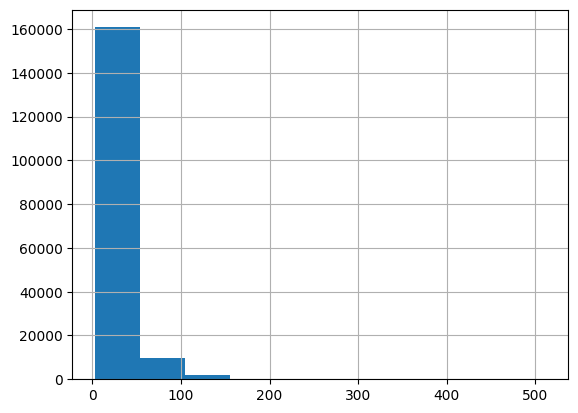

In [26]:
import pandas as pd

input_ids = dataset['train']['input_ids']
pd.Series(input_ids).apply(len).hist()

In [27]:
dataset

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 172839
    })
    test: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 57613
    })
    val: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 57613
    })
})

In [28]:
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    return {"accuracy": (preds == p.label_ids).mean()}


In [30]:
epochs = 2

training_args = TrainingArguments(
    output_dir="./bert_clf_results",
    num_train_epochs=epochs,
    per_device_train_batch_size=16,
    gradient_accumulation_steps=2,
    per_device_eval_batch_size=32,
    load_best_model_at_end=True,

    # some deep learning parameters that the Trainer is able to take in
    warmup_ratio=0.1,
    weight_decay = 0.05,

    logging_steps=1,
    log_level='info',
    eval_strategy='epoch',
    eval_steps=50,
    save_strategy='epoch'
)

# Define the trainer:

trainer = Trainer(
    model=sequence_clf_model,
    args=training_args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['val'],
    compute_metrics=compute_metrics,  # optional
    data_collator=data_collator  # technically optional
)

In [ ]:
trainer.evaluate()


***** Running Evaluation *****
  Num examples = 57613
  Batch size = 32
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


In [ ]:
trainer.train()

***** Running training *****
  Num examples = 172,839
  Num Epochs = 2
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 2
  Total optimization steps = 10,802
  Number of trainable parameters = 65,785,349


Epoch,Training Loss,Validation Loss,Accuracy
0,0.565400,0.827652,0.712738
1,0.856400,0.820736,0.717685


***** Running Evaluation *****
  Num examples = 57613
  Batch size = 32
Saving model checkpoint to ./bert_clf_results/checkpoint-10802
Configuration saved in ./bert_clf_results/checkpoint-10802/config.json
Model weights saved in ./bert_clf_results/checkpoint-10802/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./bert_clf_results/checkpoint-10802 (score: 0.8207359910011292).


TrainOutput(global_step=10802, training_loss=0.8283754970834909, metrics={'train_runtime': 7323.4982, 'train_samples_per_second': 47.201, 'train_steps_per_second': 1.475, 'total_flos': 7015951744063140.0, 'train_loss': 0.8283754970834909, 'epoch': 2.0})

In [ ]:
# See colab link for comparison on there! https://colab.research.google.com/drive/1elfu-6gaj0KWtIQMyeHYWqqkNUgA6hFn?usp=sharing
# compare to fine tuned gpt 3.5
    # accuracy
    # cost to train/host (on HF or make your own API)
    # latency/throughput


In [ ]:
trainer.evaluate(dataset['test'])  # run on the testing set to get our final test results

In [ ]:
# Deploy to HuggingFace

trainer.push_to_hub('profoz/distilbert-base-cased-finetuned-stars')

In [ ]:
from transformers import pipeline

stars_pipeline = pipeline('text-classification', 'profoz/distilbert-base-cased-finetuned-stars')

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [ ]:
stars_pipeline(
    [
        "I loved this app",
        "I hated this app"
    ]
)

[{'label': 'LABEL_4', 'score': 0.938608705997467},
 {'label': 'LABEL_0', 'score': 0.8552921414375305}]

In [ ]:
stars_pipeline.model.config.id2label = ['1 star', '2 stars', '3 stars', '4 stars', '5 stars']

In [ ]:
stars_pipeline(
    [
        "I loved this app",
        "I hated this app"
    ]
)

[{'label': '5 stars', 'score': 0.938608705997467},
 {'label': '1 star', 'score': 0.8552921414375305}]

# Using the inference endpoint for our model

In [ ]:
import requests

API_URL = "https://t7gvgsj77yrypla7.us-east-1.aws.endpoints.huggingface.cloud"
headers = {
	"Accept" : "application/json",
	"Content-Type": "application/json"
}

def query(payload):
	response = requests.post(API_URL, headers=headers, json=payload)
	return response.json()

output = query({
	"inputs": "I loved this app",
	"parameters": {}
})
output

[{'label': 'LABEL_4', 'score': 0.938608705997467}]

In [ ]:
output = query({
	"inputs": "I hated this app",
	"parameters": {}
})
output

[{'label': 'LABEL_0', 'score': 0.8552921414375305}]